In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

**Описание данных**
* timestamp – дата и время (точность до часа)
* cnt – количество аренд велосипедов за этот час
* t1 – температура, в С
* t2 – температура "ощущается как", в С 
* hum – влажность (%)
* wind_speed – скорость ветра, км/ч
* weather_code – погодные условия:  
1 – ясно (SKC)/  
2 – преимущественно ясно / встречаются отдельные облака (SCT)  
3 – облачно / значительные облака (BKN)  
4 – пасмурно (OVC)  
7 – небольшой дождь Rain/ light Rain shower/ Light rain   
10 – дождь с грозой  
26 – снегопад   
94 – ледяной туман (да, такое бывает!)
* isholiday – является ли день праздником (1 – праздник, 0 – нет)
* isweekend –  является ли день выходным (1 – выходной, 0 – нет)
* season – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)

In [2]:
df = pd.read_csv('london.csv')
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [3]:
df.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

<Axes: xlabel='timestamp', ylabel='cnt'>

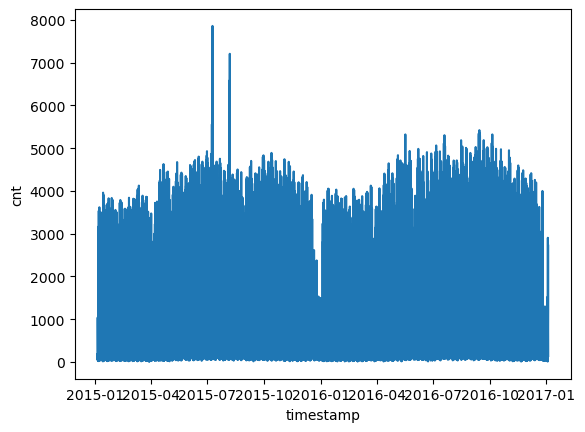

In [57]:
sns.lineplot(x=df.timestamp, y=df.cnt)

ничего не удалось понять через этот график

In [21]:
df.dtypes

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [24]:
df.timestamp = pd.to_datetime(df['timestamp'])

Агрегируем число поездок по дням и визуализируем результат.  
Вывод:  
Максимальное число аренд за день составляет более 70 000  
Встречаются как очень резкие скачки числа аренд, так и падения  
Зимой число аренд меньше, чем летом

<Axes: xlabel='timestamp'>

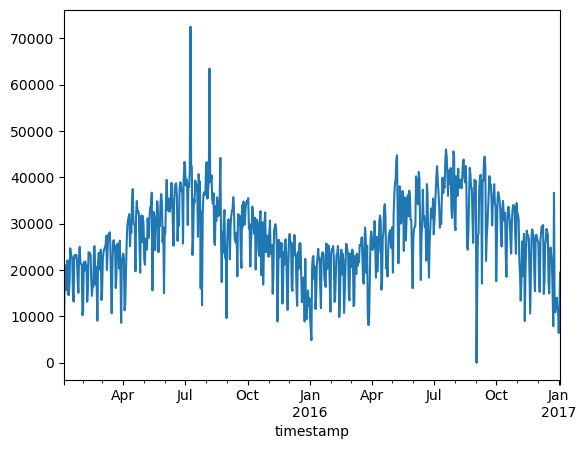

In [26]:
df_new = df.sort_values('timestamp').set_index('timestamp')

df_new.resample(rule='D').cnt.sum().plot()

Чтобы учесть  временный ряд - последовательность значений, меняющейся во времени. Мы не можем просто так посчитать доверительный интервал для всего: так мы можем упустить важные характеристики данных.Например,сезонные колебания.  
Чтобы учесть этот момент, мы построим доверительный интервал, используя скользящее среднее.  
Для этого разделим дальнейшие действия на несколько этапов:  
1. сначала посчитаем скользящее среднее, чтобы сгладить ряд  
2. далее – разницу между наблюдаемыми и сглаженными значениями  
3. определим верхние и нижние границы 99% доверительного интервала   
4. найдем причины аномалий

In [32]:
df_new.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [38]:
df_resampled = df_new.resample(rule='D').cnt.sum().reset_index()
df_resampled['sma'] = df_resampled['cnt'].rolling(window=3).mean()
df_resampled

,timestamp,cnt,sma
0,2015-01-04,9234,NaN
1,2015-01-05,20372,NaN
2,2015-01-06,20613,16739.666667
3,2015-01-07,21064,20683.000000
4,2015-01-08,15601,19092.666667
...,...,...,...
726,2016-12-30,11566,12682.000000
727,2016-12-31,11424,12347.333333
728,2017-01-01,6421,9803.666667
729,2017-01-02,11823,9889.333333


In [45]:
difference = df_resampled['sma']-df_resampled['cnt']
std = np.std(difference)
std

4558.586641117938

In [47]:
df_resampled['upper_bound'] = df_resampled['sma']+ 2.576*std
df_resampled['lower_bound'] = df_resampled['sma'] - 2.576*std
df_resampled.tail()

,timestamp,cnt,sma,upper_bound,lower_bound
726,2016-12-30,11566,12682.000000,24424.919188,939.080812
727,2016-12-31,11424,12347.333333,24090.252521,604.414146
728,2017-01-01,6421,9803.666667,21546.585854,-1939.252521
729,2017-01-02,11823,9889.333333,21632.252521,-1853.585854
730,2017-01-03,19436,12560.000000,24302.919188,817.080812


наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала

In [50]:
df_resampled.query('cnt>upper_bound')

,timestamp,cnt,sma,upper_bound,lower_bound
186,2015-07-09,72504,50705.000000,62447.919188,38962.080812
214,2015-08-06,63468,46627.333333,58370.252521,34884.414146
609,2016-09-04,27512,14259.000000,26001.919188,2516.080812
721,2016-12-25,36653,19650.666667,31393.585854,7907.747479


2015-07-09 значение числа аренд оказалось наибольшим.
причина столь высокого числа аренд в этот день - это транспортный хаос из-за забастовки в метро в Лондоне

In [51]:
df_resampled.query('cnt<lower_bound')

,timestamp,cnt,sma,upper_bound,lower_bound
130,2015-05-14,15609,28709.333333,40452.252521,16966.414146
189,2015-07-12,23240,36036.666667,47779.585854,24293.747479
201,2015-07-24,16034,31013.666667,42756.585854,19270.747479
232,2015-08-24,17400,29529.333333,41272.252521,17786.414146
314,2015-11-14,8898,21037.333333,32780.252521,9294.414146
607,2016-09-02,0,26086.333333,37829.252521,14343.414146
615,2016-09-10,17080,31262.000000,43004.919188,19519.080812
621,2016-09-16,21967,36193.333333,47936.252521,24450.414146
678,2016-11-12,8990,20878.000000,32620.919188,9135.080812


здесь скорее всего ошибка при сборе данных